In [1]:
import pandas as pd
import random
import re
import numpy as np
import operator
import datetime
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pickle
from collections import Counter, defaultdict

In [2]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [3]:
data = pd.read_csv('data/2_processed_data.csv')

#### Remove any instances with no flair tag

In [4]:
data = data[data['flair'].notna()]
flairs = np.unique(data.flair)

In [6]:
flairs

array(['AskIndia', 'Business/Finance', 'CAA-NRC', 'CAA-NRC-NPR',
       'Coronavirus', 'Demonetization', 'Food', 'Non-Political',
       'Official Sadness Thread', 'Old', 'Original Comics', 'Photography',
       'Policy & Economy', 'Policy/Economy',
       'Policy/Economy -2017 Article ', 'Politics',
       'Politics -- Source in comments', 'Politics [Megathread]',
       'Scheduled', 'Science/Technology', 'Sports', 'Totally real',
       'Unverified', 'Zoke Tyme', '[R]eddiquette'], dtype=object)

In [7]:
data.head()

,flair,title,score,id,url,comms_num,created,body,author,comments,authors,feature_combine
0,Politics -- Source in comments,mumbai students protesting caa nrc wankhede st...,1391,eok4qb,https://i.redd.it/y4jcbkiedqa41.jpg,116,1.579031e+09,NaN,Gavthi_Batman,im extremely biased towards ktm duke 200 390 i...,I'm extremely biased towards the KTM Duke (bo...,mumbai students protesting caa nrc wankhede st...
1,Politics -- Source in comments,amit shah looking source comment,16,fbx2it,https://i.redd.it/6heuj8xxf3k41.png,4,1.583112e+09,NaN,sickcooler,im extremely biased towards ktm duke 200 390 i...,I'm extremely biased towards the KTM Duke (bo...,amit shah looking source comment im extremely ...
2,Politics -- Source in comments,real loser indias errupting islamaphobia caste...,81,g76o5f,https://www.reddit.com/r/india/comments/g76o5f...,53,1.587756e+09,tldr unqualified opinion dalit political movem...,HairLikeWinterFire,im extremely biased towards ktm duke 200 390 i...,I'm extremely biased towards the KTM Duke (bo...,real loser indias errupting islamaphobia caste...
3,Politics -- Source in comments,annual reminder indias ayush minister promised...,398,fu1ly8,https://www.reddit.com/r/india/comments/fu1ly8...,43,1.585917e+09,spoiler dont please note said prevention cure ...,madamplease,im extremely biased towards ktm duke 200 390 i...,I'm extremely biased towards the KTM Duke (bo...,annual reminder indias ayush minister promised...
4,Politics -- Source in comments,mp covid19 megathread,21,fpt2jw,https://www.reddit.com/r/india/comments/fpt2jw...,19,1.585325e+09,thread sharing coronavirus news updates relate...,maardon_bhenji,im extremely biased towards ktm duke 200 390 i...,I'm extremely biased towards the KTM Duke (bo...,mp covid19 megathread im extremely biased towa...


#### Checking data distribution

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 12 columns):
flair              2073 non-null object
title              2073 non-null object
score              2073 non-null int64
id                 2073 non-null object
url                2073 non-null object
comms_num          2073 non-null int64
created            2073 non-null float64
body               1206 non-null object
author             2073 non-null object
comments           2073 non-null object
authors            2073 non-null object
feature_combine    2073 non-null object
dtypes: float64(1), int64(2), object(9)
memory usage: 210.5+ KB


In [9]:
data.flair.value_counts()

Totally real                      100
Non-Political                     100
Policy/Economy                    100
Sports                            100
CAA-NRC                           100
AskIndia                          100
Coronavirus                       100
Scheduled                         100
Policy/Economy -2017 Article      100
Politics                          100
Food                              100
Unverified                        100
Business/Finance                  100
CAA-NRC-NPR                       100
Demonetization                    100
Science/Technology                100
Old                               100
Politics -- Source in comments    100
Policy & Economy                  100
Photography                       100
Original Comics                    26
Zoke Tyme                          23
[R]eddiquette                      18
Politics [Megathread]               5
Official Sadness Thread             1
Name: flair, dtype: int64

#### Checking if any post has null combined feature

In [10]:
data['feature_combine'].isna().any()

False

#### Removing flairs with less than 25 posts

In [15]:
to_remove = {'Original Comics', 'Zoke Tyme', '[R]eddiquette', 'Politics [Megathread]', 'Official Sadness Thread'}
flairs = list(set(flairs) - to_remove)
n_posts_remove = 0
for ele in to_remove:
    data_new = data_new[data.flair != ele]
for ele in to_remove:
    n_posts_remove+=data['flair'].value_counts()[ele]

/home/dexter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [16]:
data_new['flair'].value_counts()

Totally real                      100
Food                              100
Policy/Economy                    100
Sports                            100
CAA-NRC                           100
AskIndia                          100
Coronavirus                       100
Scheduled                         100
Policy/Economy -2017 Article      100
Politics                          100
Unverified                        100
Non-Political                     100
Business/Finance                  100
CAA-NRC-NPR                       100
Demonetization                    100
Science/Technology                100
Old                               100
Politics -- Source in comments    100
Policy & Economy                  100
Photography                       100
Name: flair, dtype: int64

In [17]:
data_new.groupby('flair').count()['title'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8, title='Number of posts in each flair', xTitle='Flairs')

##Checking top words used in content of posts for each flair class

In [21]:
ana = defaultdict()
excep = 0
for i in range(len(data_new)):
    #ana[data['flair'][i]].value
    try:
        fl = data_new['flair'][i]
        #print(fl)
        if fl in ana:
            s = ana[fl]
            #print(ana['CAA-NRC'])
            s1 = s + ' ' + data_new['feature_combine'][i]
            ana[fl] = s1
        else:
            ana[fl] = data_new['feature_combine'][i]
    except KeyError:
        #print('Key Error at ',i)
        excep+=1
        continue

In [24]:
flairs = np.unique(data_new.flair)

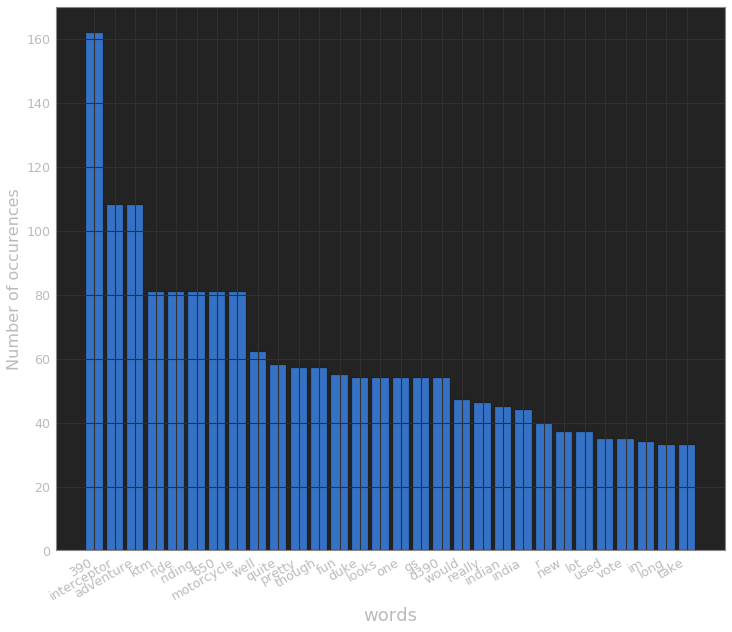

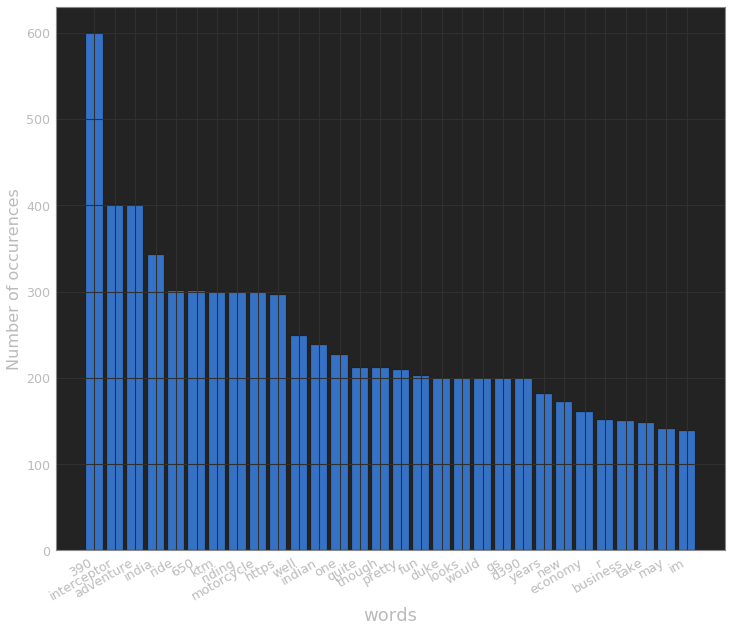

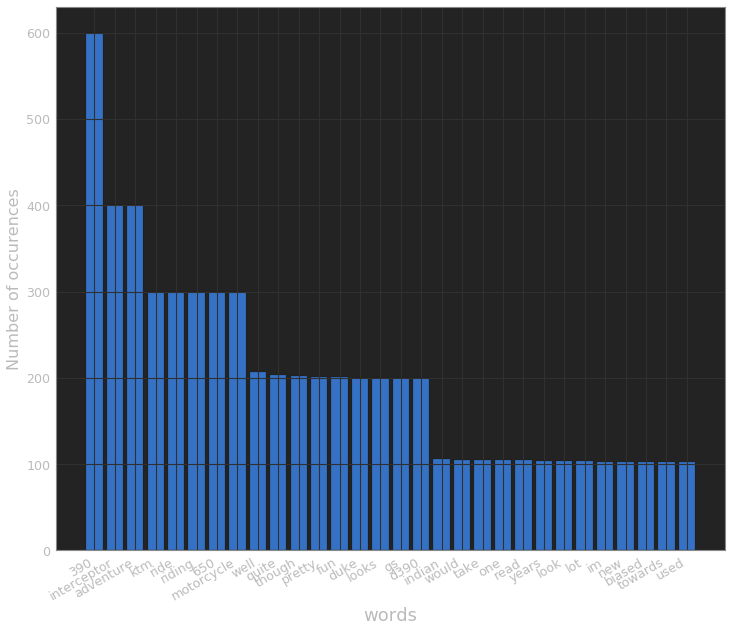

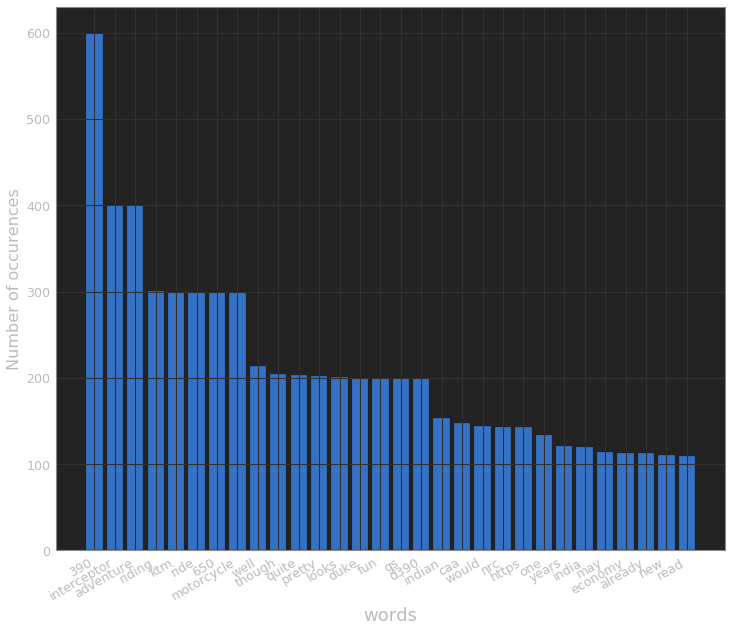

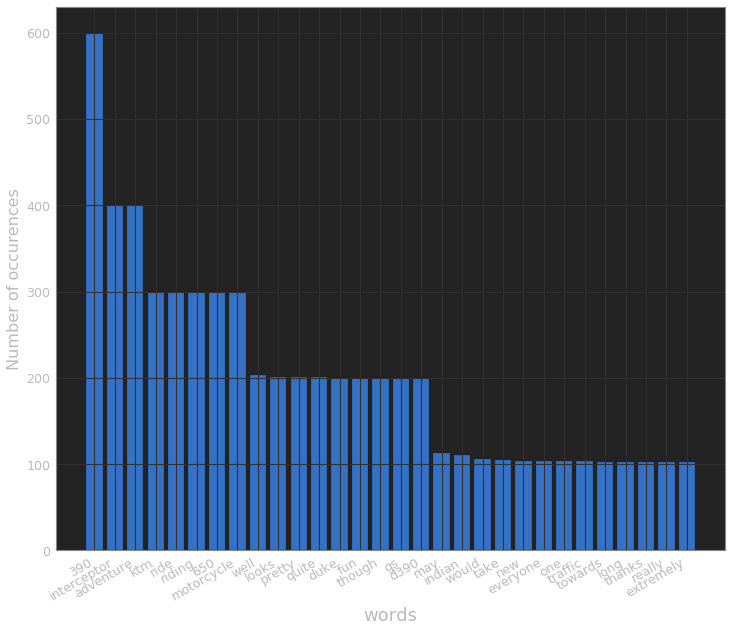

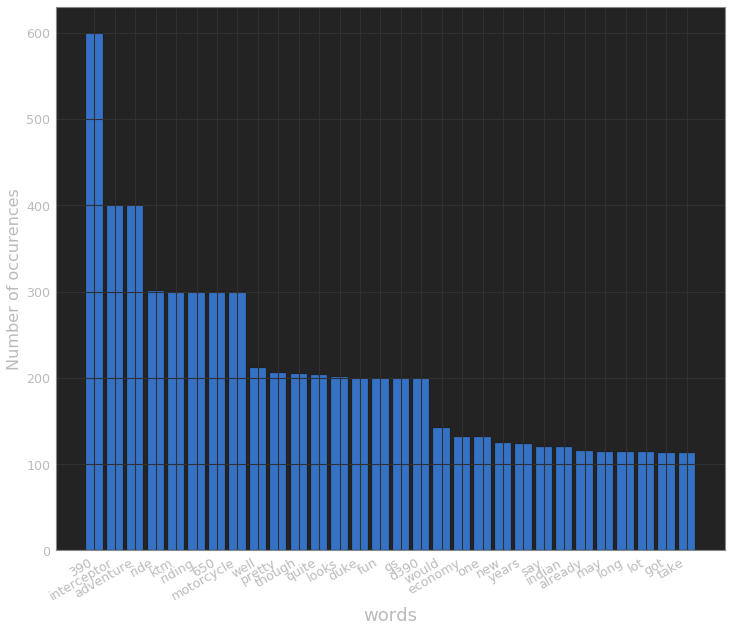

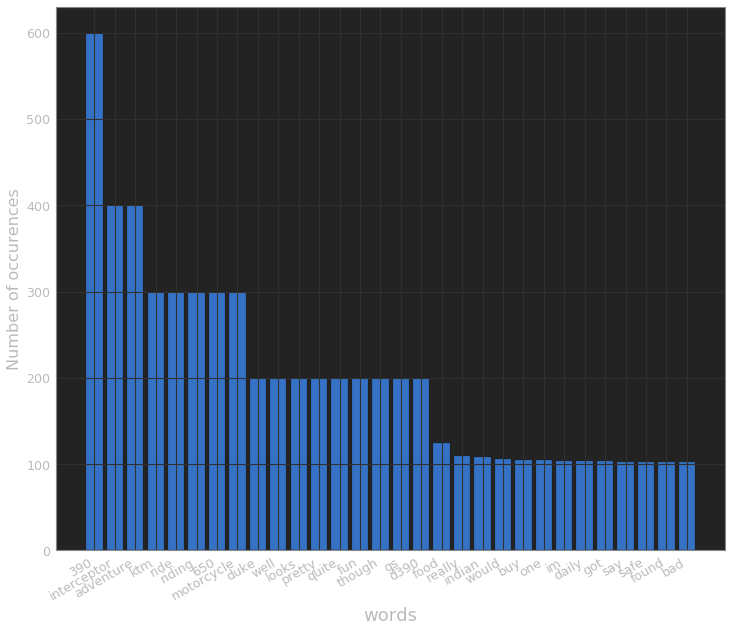

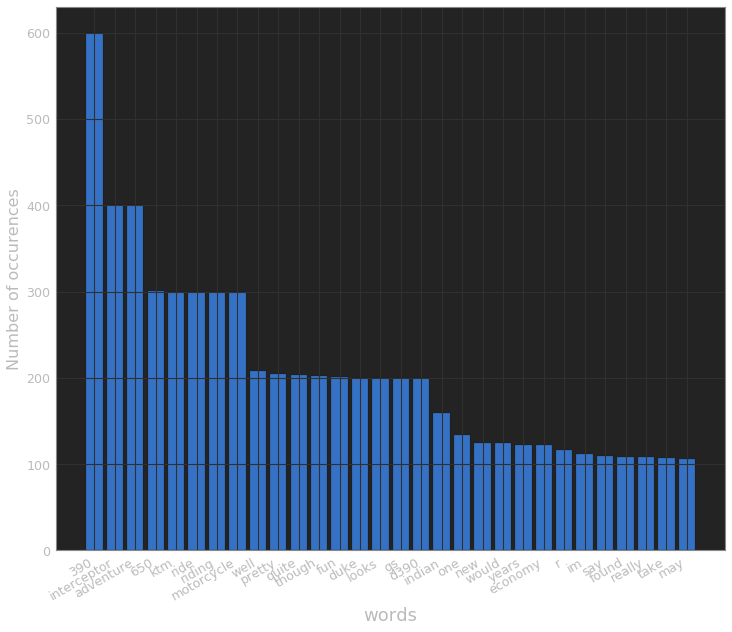

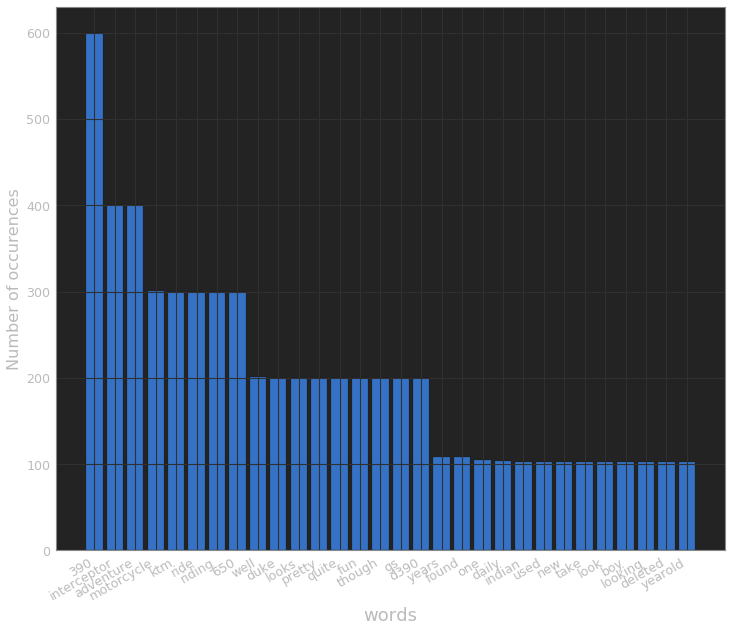

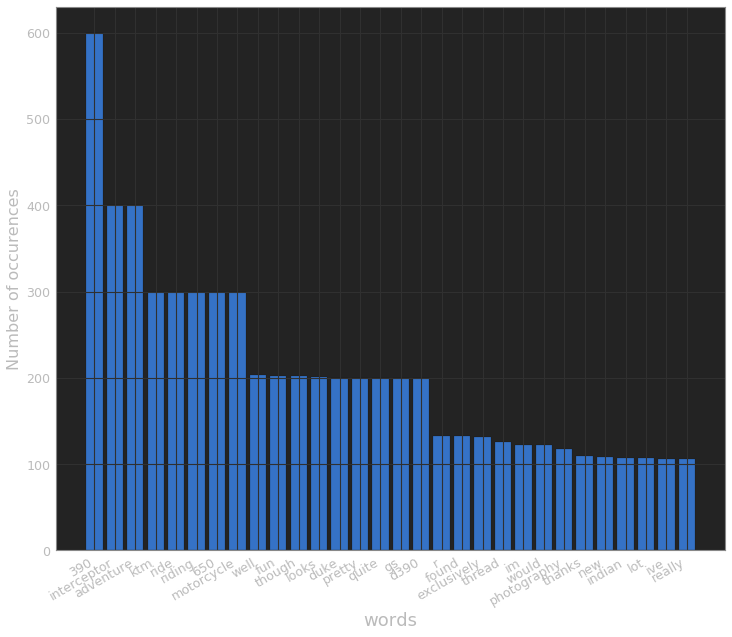

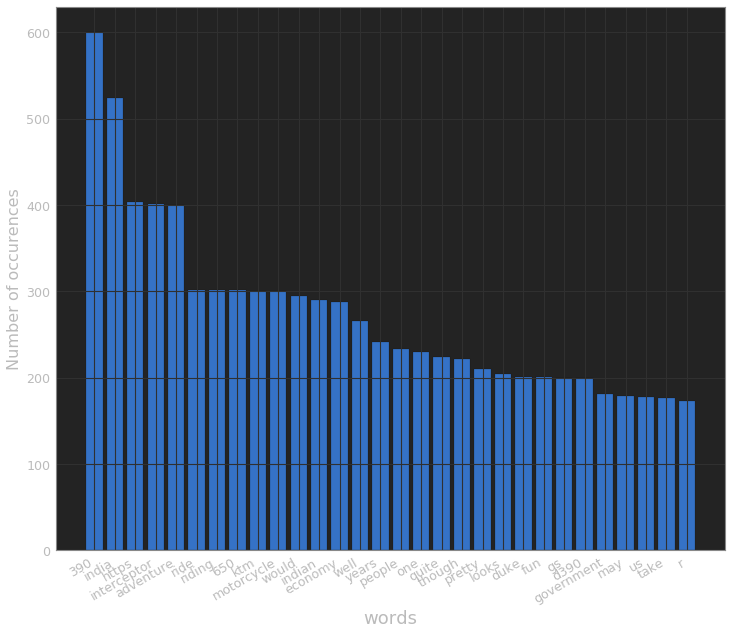

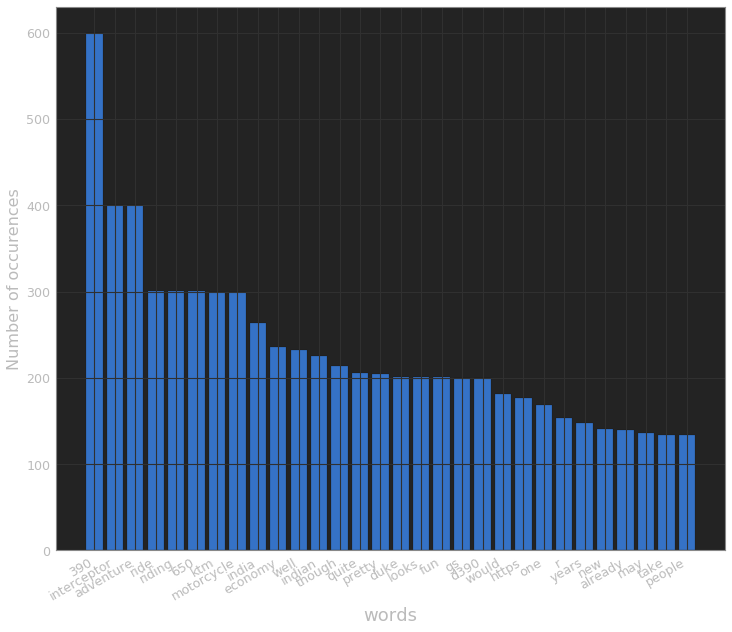

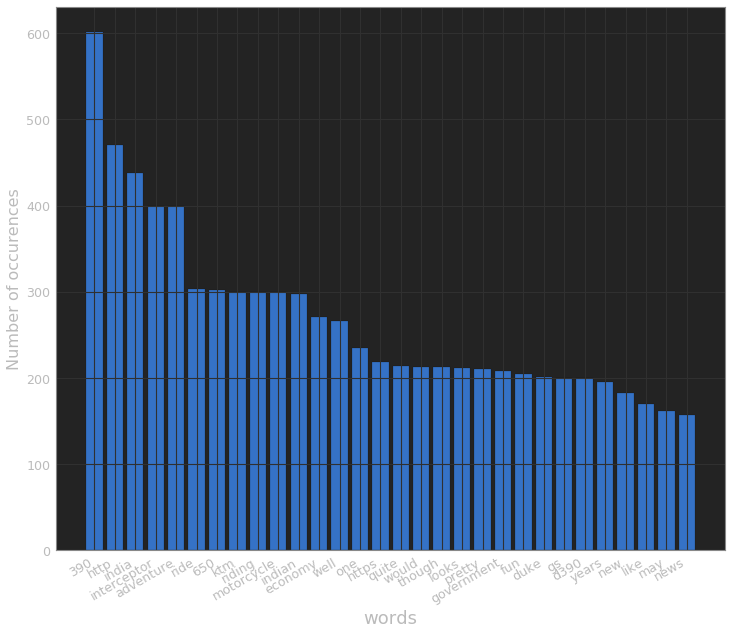

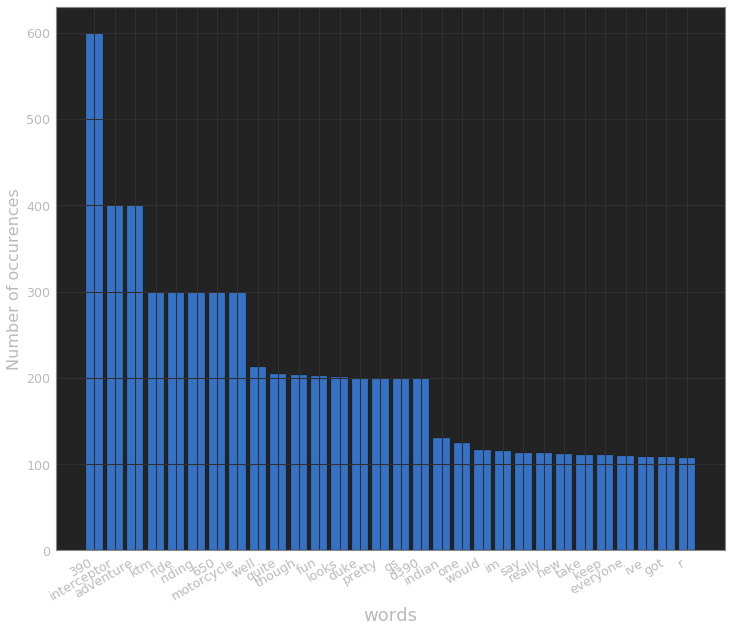

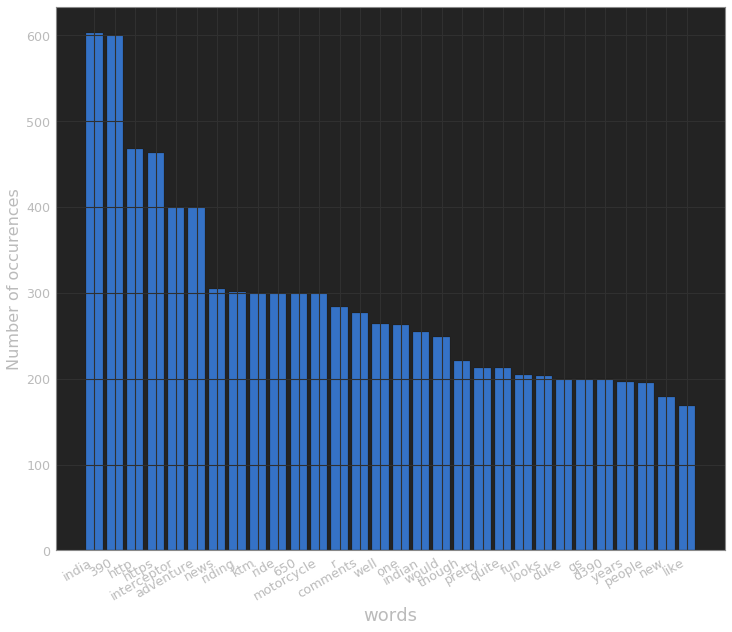

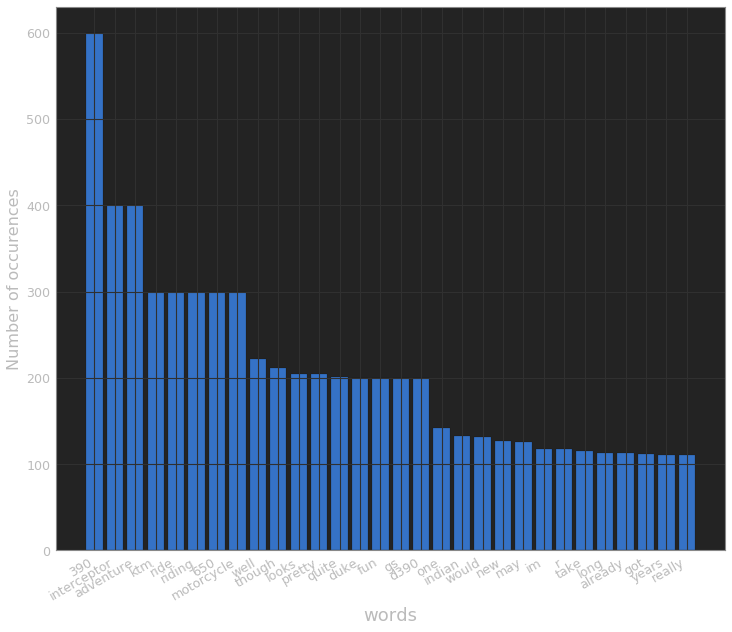

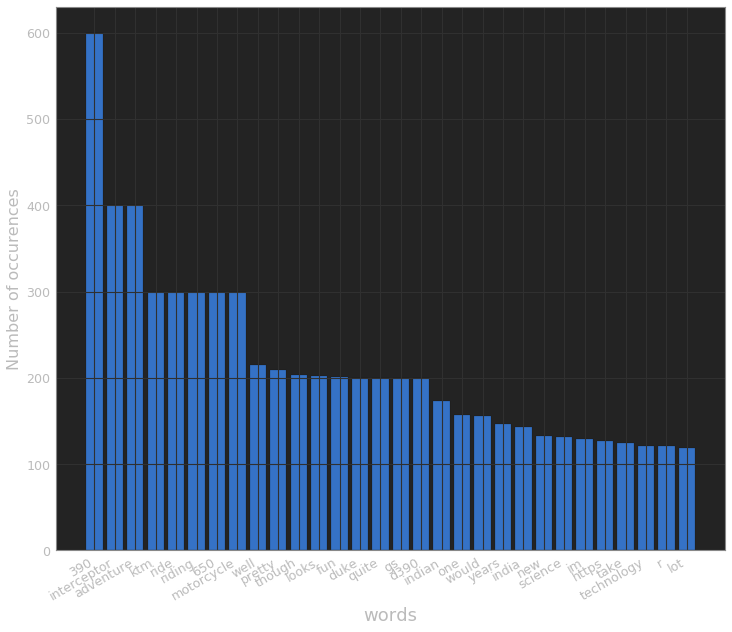

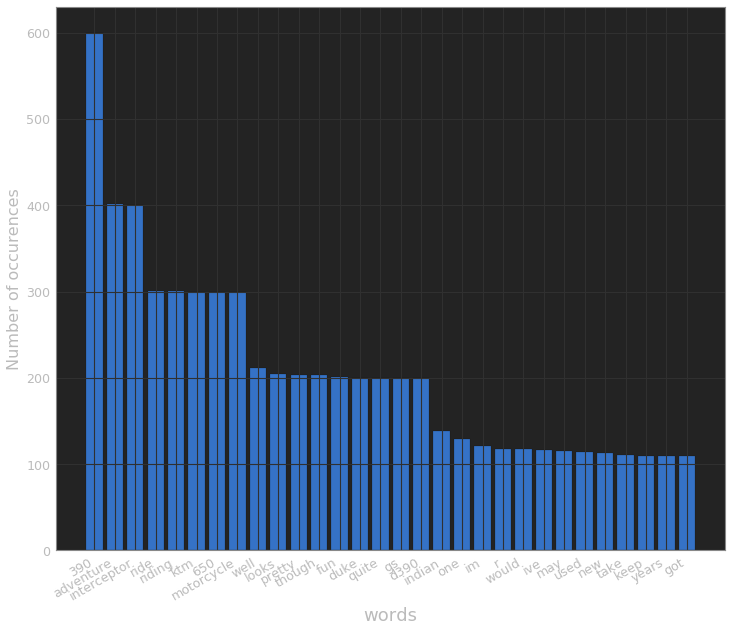

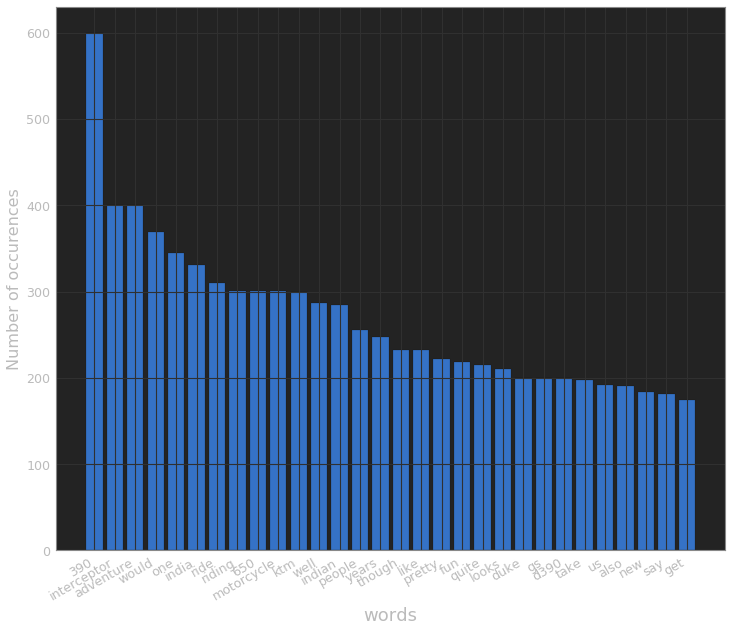

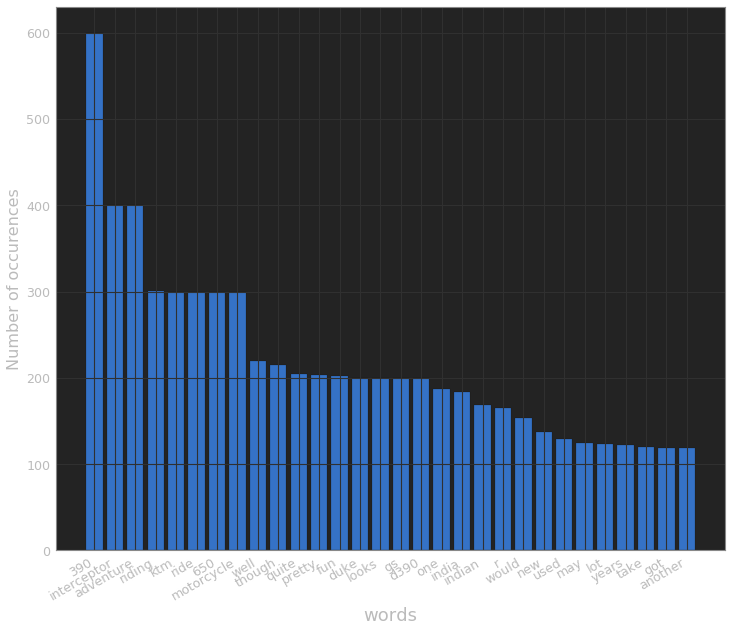

In [26]:
for i in flairs:
    plt.figure(figsize = [12,10])
    ax = plt.axes()
    #print(flairs)
    freqs = Counter(ana[i].split())
    f =sorted(freqs.items(), key = operator.itemgetter(1) ,reverse = True)
    ax.bar(dict(f[:30]).keys(), dict(f[:30]).values(), edgecolor='black')
    plt.xlabel('words', fontsize=18)
    plt.ylabel('Number of occurences', fontsize=16)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

#### Conclusion: Considering the distribution of popular words, random forest, Gradient Boosting seem to be the optimal algorithms. data is not enough to train a LSTM model

In [28]:
comms_num_freq = defaultdict()
excep = 0
for i in range(len(data_new)):
    #ana[data['flair'][i]].value
    try:
        fl = data_new['flair'][i]
        #print(fl)
        if fl in comms_num_freq:
            s = comms_num_freq[fl]
            #print(ana['CAA-NRC'])
            s1 = s + data_new['comms_num'][i]
            comms_num_freq[fl] = s1
        else:
            comms_num_freq[fl] = data_new['comms_num'][i]
    except KeyError:
        #print('Key Error at ',i)
        excep+=1
        continue

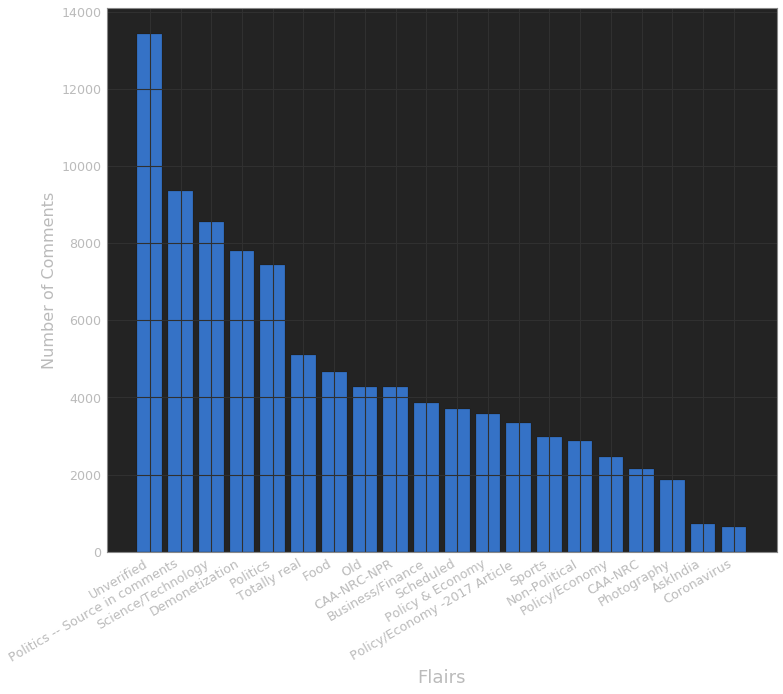

In [30]:
plt.figure(figsize = [12,10])
#print(flairs)
ax = plt.axes()
freqs = comms_num_freq
f =sorted(freqs.items(), key = operator.itemgetter(1) ,reverse = True)
ax.bar(dict(f[:30]).keys(), dict(f[:30]).values(), edgecolor='black')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xlabel('Flairs', fontsize=18)
plt.ylabel('Number of Comments', fontsize=16)
plt.show()

In [32]:
authors = defaultdict()
excep = 0
for i in range(len(data_new)):
    try:
        fl = data_new['flair'][i]
        if fl in ana:
            s = ana[fl]
            #print(ana['CAA-NRC'])
            s1 = s + ' ' + data_new['feature_combine'][i]
            authors[fl] = s1
        else:
            authors[fl] = data_new['feature_combine'][i]
    except KeyError:
        #print('Key Error at ',i)
        excep+=1
        continue

In [33]:
data_new.groupby('flair').count()['author'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=1, title='Number of Authors in each flair', xTitle='Flairs')

In [34]:
data_new.groupby('flair').count()

,title,score,id,url,comms_num,created,body,author,comments,authors,feature_combine
flair,,,,,,,,,,,
AskIndia,100,100,100,100,100,100,100,100,100,100,100
Business/Finance,100,100,100,100,100,100,77,100,100,100,100
CAA-NRC,100,100,100,100,100,100,18,100,100,100,100
CAA-NRC-NPR,100,100,100,100,100,100,35,100,100,100,100
Coronavirus,100,100,100,100,100,100,12,100,100,100,100
Demonetization,100,100,100,100,100,100,49,100,100,100,100
Food,100,100,100,100,100,100,23,100,100,100,100
Non-Political,100,100,100,100,100,100,46,100,100,100,100
Old,100,100,100,100,100,100,11,100,100,100,100


#### Conclusion: Contrary to my earlier intuition, only body cannot be used as a feature for classification, because only body has some null values

In [36]:
##Timestamp of posts

In [37]:
df = data_new
df['created'] = pd.to_datetime(df['created'])
df = df.set_index('created')
df['day'] = df.index.date
counts = df.groupby(['day', 'flair']).agg(len)
#counts = pd.DataFrame(counts, columns=['count'])

/home/dexter/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



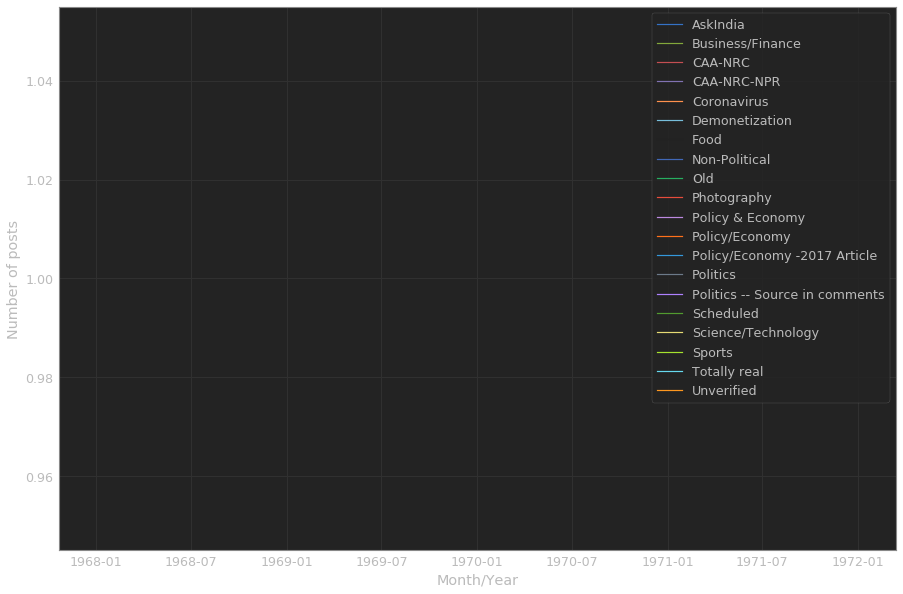

In [38]:
times = []
plt.figure(figsize=[15,10])
for f in flairs:
    l = defaultdict.fromkeys(['count', 'timestamp'])
    l['count'] = []
    c = 0
    l['timestamp'] = []
    #print(f)
    for i in range(len(counts)):
        j = counts.index[i]
        if j[1]==f:
            c+=1
            l['count'].append(c)
            l['timestamp'].append(j[0])
    plt.plot(l['timestamp'], l['count'], label = f)
plt.xlabel("Month/Year")
plt.ylabel("Number of posts")
plt.legend()
plt.show()

##Similar trends in many flairs. Using timestamp as a feature may not be very helpful

In [40]:
data_new.to_csv("data/4_final_dataset.csv")

### Conclusion: Use body, comments, title and url as features